### Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os
import sys
import time

### Hardware Accelerator Check

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Preparation

In [4]:
# defining data transforms for train and test datasets

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [5]:
# importing CIFAR10 train and test datasets

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# number of data points in train dataset

trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [7]:
# number of data points in test dataset

testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [8]:
# creating data loaders for train and test datasets

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


In [9]:
# The different classes in CIFAR10 dataset are

trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### ResNet18 NN Basic Block

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, conv_kernel_size = 3, skip_connection_kernel_size = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = conv_kernel_size, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = conv_kernel_size, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = skip_connection_kernel_size, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### ResNet18 Architecture

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channels, conv_kernel_size, skip_connection_kernel_size, avg_maxPool_size, num_classes = 10):
        super(ResNet, self).__init__()
        self.input = channels[0]
        self.conv_kernel_size = conv_kernel_size
        self.skip_connection_kernel_size = skip_connection_kernel_size
        self.avg_maxPool_size = avg_maxPool_size

        self.conv1 = nn.Conv2d(3, channels[0], kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.layer1 = self._make_layer(block[0], channels[0], num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block[1], channels[1], num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block[2], channels[2], num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block[3], channels[3], num_blocks[3], stride = 2)
        self.linear = nn.Linear(channels[3] * block[3].expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.input, out_channels, stride, self.conv_kernel_size, self.skip_connection_kernel_size))
            self.input = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, self.avg_maxPool_size)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

### Initialize the Model

In [13]:
net = ResNet([BasicBlock, BasicBlock, BasicBlock, BasicBlock], [2, 2, 2, 2], [64, 128, 232, 268], 3, 1, 4).to(device)  # Reaches ~80% within 5 epochs
summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [14]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print("Device is set to CUDA")

Device is set to CUDA


In [15]:
best_acc = 0  # best test accuracy
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

### Define Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Training

In [ ]:
# def train(epoch):
#     print('\nEpoch: %d' % epoch)
#     net.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(trainloader):
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()

#     print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

### Testing

In [ ]:
# def test(epoch):
#     global best_acc
#     net.eval()
#     test_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(testloader):
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = net(inputs)
#             loss = criterion(outputs, targets)

#             test_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += targets.size(0)
#             correct += predicted.eq(targets).sum().item()

#         print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

#     # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt.pth')
#         best_acc = acc


### Train and Evaluate


Epoch: 0
Train Loss: 1.673 | Train Acc: 38.244% (19122/50000)
Test Loss: 1.351 | Test Acc: 50.900% (5090/10000)
Saving..

Epoch: 1
Train Loss: 1.159 | Train Acc: 58.224% (29112/50000)
Test Loss: 1.067 | Test Acc: 63.150% (6315/10000)
Saving..

Epoch: 2
Train Loss: 0.897 | Train Acc: 68.198% (34099/50000)
Test Loss: 0.986 | Test Acc: 64.060% (6406/10000)
Saving..

Epoch: 3
Train Loss: 0.727 | Train Acc: 74.792% (37396/50000)
Test Loss: 0.699 | Test Acc: 75.920% (7592/10000)
Saving..

Epoch: 4
Train Loss: 0.638 | Train Acc: 77.982% (38991/50000)
Test Loss: 0.833 | Test Acc: 72.240% (7224/10000)

Epoch: 5
Train Loss: 0.582 | Train Acc: 79.840% (39920/50000)
Test Loss: 0.695 | Test Acc: 76.690% (7669/10000)
Saving..

Epoch: 6
Train Loss: 0.531 | Train Acc: 81.720% (40860/50000)
Test Loss: 0.804 | Test Acc: 73.870% (7387/10000)

Epoch: 7
Train Loss: 0.504 | Train Acc: 82.790% (41395/50000)
Test Loss: 0.728 | Test Acc: 74.720% (7472/10000)

Epoch: 8
Train Loss: 0.486 | Train Acc: 83.292% (4

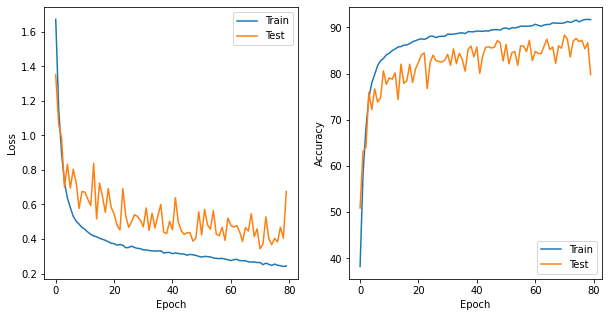

In [17]:
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
test_losses = []
test_accs = []

def train(epoch):
    global train_losses, train_accs
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss/(batch_idx+1))
    train_accs.append(100.*correct/total)
    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'% (train_losses[-1], train_accs[-1], correct, total))

def test(epoch):
    global best_acc, test_losses, test_accs
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        test_losses.append(test_loss/(batch_idx+1))
        test_accs.append(100.*correct/total)
        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'% (test_losses[-1], test_accs[-1], correct, total))

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc

# Train and test the model for multiple epochs
for epoch in range(start_epoch, 80):
    train(epoch)
    test(epoch)
    scheduler.step()

# Plot the training and testing curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(test_accs,label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()